In [1]:
import tensorflow as tf
print("Versión de tensorflow:{}".format(tf.__version__))
print("GPU:{}".format(tf.test.gpu_device_name()))

Versión de tensorflow:2.3.0
GPU:/device:GPU:0


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
import os 
os.listdir('.')

['.ipynb_checkpoints',
 'cassava-disease',
 'Cassava_best_modelP8.h5',
 'Cassava_best_modelR.h5',
 'Cassava_best_modelR2.h5',
 'Cassava_best_modelVGG16.h5',
 'Cassava_best_modelXception.h5',
 'FineTuningP8.ipynb',
 'FineTuningResNet.ipynb',
 'FineTuningResNet2.ipynb',
 'FineTuningResNet3.ipynb',
 'FineTuningVGG16.ipynb',
 'FineTuningXception.ipynb',
 'foo.png',
 'Primera Base Xception.ipynb',
 'PRIMERA COMPETENCIA',
 'PrimeraBaseXception.h5',
 'Segunda Base ResNet50.ipynb',
 'Segunda Base Xception.ipynb',
 'SEGUNDA COMPETENCIA',
 'SegundaBaseResNet50.h5',
 'SegundaBaseXception.h5',
 'test 2']

In [6]:
# Verificación de lo que hay en la carpeta Kaggle
PATH = 'cassava-disease'

os.listdir(PATH)

['CONFUNDIDAS',
 'Confundidas por el modelo',
 'test',
 'test 2',
 'trainCompletaMod3',
 'trainCompletaMod4',
 'trainCompletaMod5.1',
 'Validacion1',
 'Validacion2']

In [7]:
base_dir = os.path.join(os.path.dirname(PATH), 'cassava-disease')
train_dir = os.path.join(base_dir, 'trainCompletaMod5.1')
test_dir = os.path.join(base_dir, 'test 2')

train_cbb_dir = os.path.join(train_dir, 'cbb')  
train_cbsd_dir = os.path.join(train_dir, 'cbsd')  
train_cgm_dir = os.path.join(train_dir, 'cgm')  
train_cmd_dir = os.path.join(train_dir, 'cmd')  
train_healthy_dir = os.path.join(train_dir, 'healthy')  

In [8]:
num_cbb_tr = len(os.listdir(train_cbb_dir))
num_cbsd_tr = len(os.listdir(train_cbsd_dir))
num_cgm_tr = len(os.listdir(train_cgm_dir))
num_cmd_tr = len(os.listdir(train_cmd_dir))
num_healthy_tr = len(os.listdir(train_healthy_dir))


total_train = num_cbb_tr + num_cbsd_tr + num_cgm_tr + num_cmd_tr + num_healthy_tr

In [10]:
print('total training cbb images:', num_cbb_tr)
print('total training cbsd images:', num_cbsd_tr)
print('total training cgm images:', num_cgm_tr)
print('total training cmd images:', num_cmd_tr)
print('total training healthy images:', num_healthy_tr)

print("--")
print("Total training images:", total_train)

total training cbb images: 1224
total training cbsd images: 1224
total training cgm images: 1224
total training cmd images: 1224
total training healthy images: 1224
--
Total training images: 6120


In [11]:
BATCH_SIZE = 8  
IMG_SHAPE  = 299  

In [12]:
train_image_generator      = ImageDataGenerator(rescale=1./255,
                                               validation_split=0.1022,
                                               rotation_range = 45,
                                               zoom_range = 0.2,
                                               vertical_flip=True,
                                               horizontal_flip=True,
                                               fill_mode = 'nearest',
                                               shear_range = 0.1,
                                               height_shift_range = 0.1,
                                               width_shift_range = 0.1)  

In [13]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,                                                    
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE),
                                                           class_mode='sparse',
                                                           subset='training')

Found 5495 images belonging to 5 classes.


In [14]:
NUM_TRAINING_IMAGES=5495

In [15]:
val_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=train_dir,                                                              
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), 
                                                              class_mode='sparse',
                                                              subset='validation')

Found 625 images belonging to 5 classes.


In [16]:
NUM_VALIDATION_IMAGES=625

In [37]:
sample_training_images, _ = next(train_data_gen) 

In [38]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

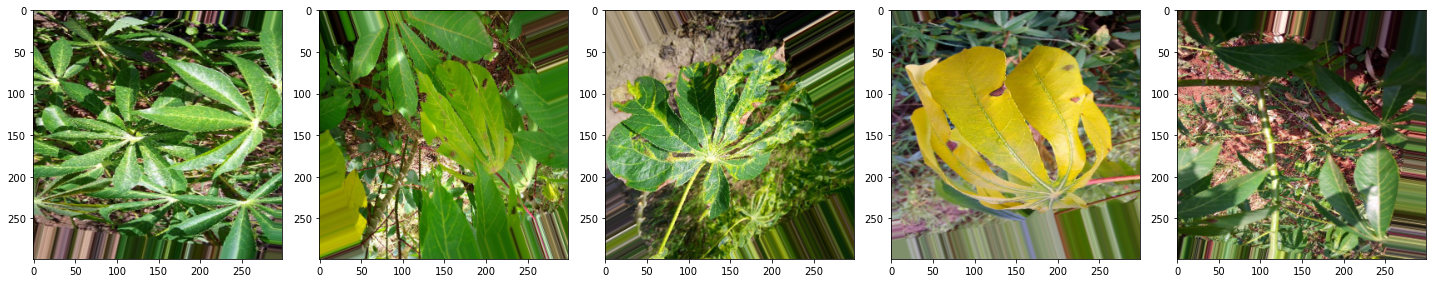

In [39]:
plotImages(sample_training_images[:5]) 

In [17]:
model1 = tf.keras.applications.ResNet50(weights='imagenet')

In [18]:
model1.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
pre_trained_model = tf.keras.applications.ResNet50(input_shape=(IMG_SHAPE, IMG_SHAPE, 3), include_top=False, weights="imagenet")

In [21]:
for layer in pre_trained_model.layers[:]:
   layer.trainable = False

print('conv_base is now NOT trainable')

conv_base is now NOT trainable


In [43]:
from tensorflow.keras import backend as K


In [44]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.zeros_like(layer.moving_variance)))
    else:
        layer.trainable = False

print(len(pre_trained_model.layers))

input_4
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [22]:
# PARA SABER QUE CAPAS SE ESTAN ENTRENANDO
for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name, layer.trainable)

0 input_2 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn False
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn False
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn False
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn False
16 conv2_block1_3_bn False
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn False
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn False
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn False
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn False
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn False
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn False
37 conv2_block3_add False
38 conv2_bloc

In [46]:
last_layer = pre_trained_model.get_layer('conv5_block3_1_conv')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 10, 10, 512)


# Modelo

In [23]:
model = tf.keras.Sequential([
        pre_trained_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Flatten(),
        #tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1024, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
        tf.keras.layers.Dense(512, activation="relu",kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 2565      
Total params: 26,213,253
Trainable params: 2,625,541
Non-trainable params: 23,587,712
____________________________________

In [ ]:
# PARA SABER QUE CAPAS SE ESTAN ENTRENANDO
for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name, layer.trainable)

In [49]:
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE

In [50]:
EPOCHS = 20
history = model.fit(
    train_data_gen, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_data_gen,
    validation_steps=VALID_STEPS)

Epoch 1/20
686/686 [==============================] - 246s 359ms/step - loss: 2.9462 - acc: 0.6222 - val_loss: 0.8027 - val_acc: 0.8029
Epoch 2/20
686/686 [==============================] - 238s 347ms/step - loss: 0.8865 - acc: 0.7436 - val_loss: 0.6898 - val_acc: 0.8189
Epoch 3/20
686/686 [==============================] - 238s 347ms/step - loss: 0.7282 - acc: 0.7871 - val_loss: 0.5514 - val_acc: 0.8478
Epoch 4/20
686/686 [==============================] - 239s 348ms/step - loss: 0.6561 - acc: 0.8077 - val_loss: 0.5077 - val_acc: 0.8606
Epoch 5/20
686/686 [==============================] - 239s 348ms/step - loss: 0.6013 - acc: 0.8199 - val_loss: 0.5235 - val_acc: 0.8574
Epoch 6/20
686/686 [==============================] - 239s 348ms/step - loss: 0.5654 - acc: 0.8332 - val_loss: 0.5222 - val_acc: 0.8590
Epoch 7/20
686/686 [==============================] - 239s 348ms/step - loss: 0.5432 - acc: 0.8367 - val_loss: 0.4672 - val_acc: 0.8814
Epoch 8/20
686/686 [============================

### FINE TUNING

In [51]:
pre_trained_model.layers[165].name

'conv5_block3_1_conv'

In [52]:
for layer in pre_trained_model.layers[165:]:
    layer.trainable = True

In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 10, 10, 2048)      23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 2565      
Total params: 26,213,253
Trainable params: 7,138,181
Non-trainable params: 19,075,072
__________________________________

In [54]:
# PARA SABER QUE CAPAS SE ESTAN ENTRENANDO
for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name, layer.trainable)

0 input_4 False
1 conv1_pad False
2 conv1_conv False
3 conv1_bn True
4 conv1_relu False
5 pool1_pad False
6 pool1_pool False
7 conv2_block1_1_conv False
8 conv2_block1_1_bn True
9 conv2_block1_1_relu False
10 conv2_block1_2_conv False
11 conv2_block1_2_bn True
12 conv2_block1_2_relu False
13 conv2_block1_0_conv False
14 conv2_block1_3_conv False
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add False
18 conv2_block1_out False
19 conv2_block2_1_conv False
20 conv2_block2_1_bn True
21 conv2_block2_1_relu False
22 conv2_block2_2_conv False
23 conv2_block2_2_bn True
24 conv2_block2_2_relu False
25 conv2_block2_3_conv False
26 conv2_block2_3_bn True
27 conv2_block2_add False
28 conv2_block2_out False
29 conv2_block3_1_conv False
30 conv2_block3_1_bn True
31 conv2_block3_1_relu False
32 conv2_block3_2_conv False
33 conv2_block3_2_bn True
34 conv2_block3_2_relu False
35 conv2_block3_3_conv False
36 conv2_block3_3_bn True
37 conv2_block3_add False
38 conv2_block3_out Fals

In [55]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=["acc"])

In [56]:
checkpoint_cb = ModelCheckpoint("Cassava_best_modelR2.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)

In [57]:
EPOCHS = 20
history = model.fit(
    train_data_gen, epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=val_data_gen,
    validation_steps=VALID_STEPS,
    callbacks = [checkpoint_cb, reduce_lr])

Epoch 1/20
686/686 [==============================] - 246s 359ms/step - loss: 0.3439 - acc: 0.9023 - val_loss: 0.3732 - val_acc: 0.9119
Epoch 2/20
686/686 [==============================] - 257s 374ms/step - loss: 0.3218 - acc: 0.9096 - val_loss: 0.3740 - val_acc: 0.8974
Epoch 3/20
686/686 [==============================] - 248s 362ms/step - loss: 0.3154 - acc: 0.9103 - val_loss: 0.3524 - val_acc: 0.9151
Epoch 4/20
686/686 [==============================] - 248s 361ms/step - loss: 0.3179 - acc: 0.9129 - val_loss: 0.3460 - val_acc: 0.9038
Epoch 5/20
686/686 [==============================] - 245s 358ms/step - loss: 0.3086 - acc: 0.9132 - val_loss: 0.3650 - val_acc: 0.8926
Epoch 6/20
686/686 [==============================] - ETA: 0s - loss: 0.3082 - acc: 0.9143
Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
686/686 [==============================] - 245s 358ms/step - loss: 0.3082 - acc: 0.9143 - val_loss: 0.3801 - val_acc: 0.8974
Epoch 7/20
686/686 [===

In [58]:
from tensorflow import keras
final_model = keras.models.load_model('Cassava_best_modelR2.h5')


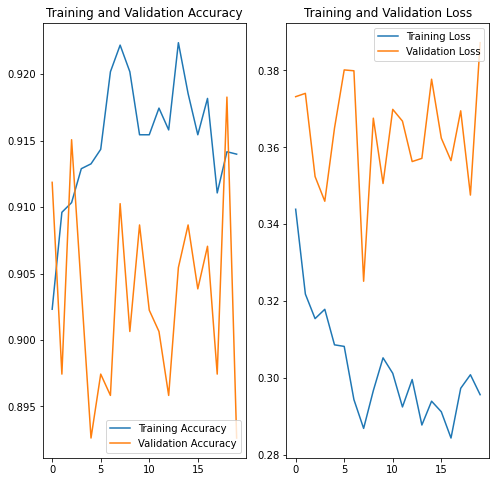

In [60]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

In [61]:
test_image_generator = ImageDataGenerator(rescale = 1./255)

In [62]:
import random
seed = random.randint(1, 1000)
test_data_gen = test_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=test_dir,                                                    
                                                           shuffle=False,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='sparse')  

Found 625 images belonging to 5 classes.


In [63]:
NUM_TEST_IMAGES = 625
TEST_STEPS = NUM_TEST_IMAGES // BATCH_SIZE

In [64]:
# Evaluación del modelo
from tensorflow.keras.models import Model, load_model
model.load_weights("Cassava_best_modelR2.h5")
evaluate = model.evaluate(test_data_gen, steps = TEST_STEPS, verbose =1)

print('Accuracy Test : {}'.format(evaluate[1]))

78/78 [==============================] - 13s 169ms/step - loss: 0.2927 - acc: 0.9295
Accuracy Test : 0.9294871687889099


              precision    recall  f1-score   support

           0     0.9048    0.9120    0.9084       125
           1     0.9417    0.9040    0.9224       125
           2     0.9828    0.9120    0.9461       125
           3     0.9512    0.9360    0.9435       125
           4     0.8786    0.9840    0.9283       125

    accuracy                         0.9296       625
   macro avg     0.9318    0.9296    0.9297       625
weighted avg     0.9318    0.9296    0.9297       625



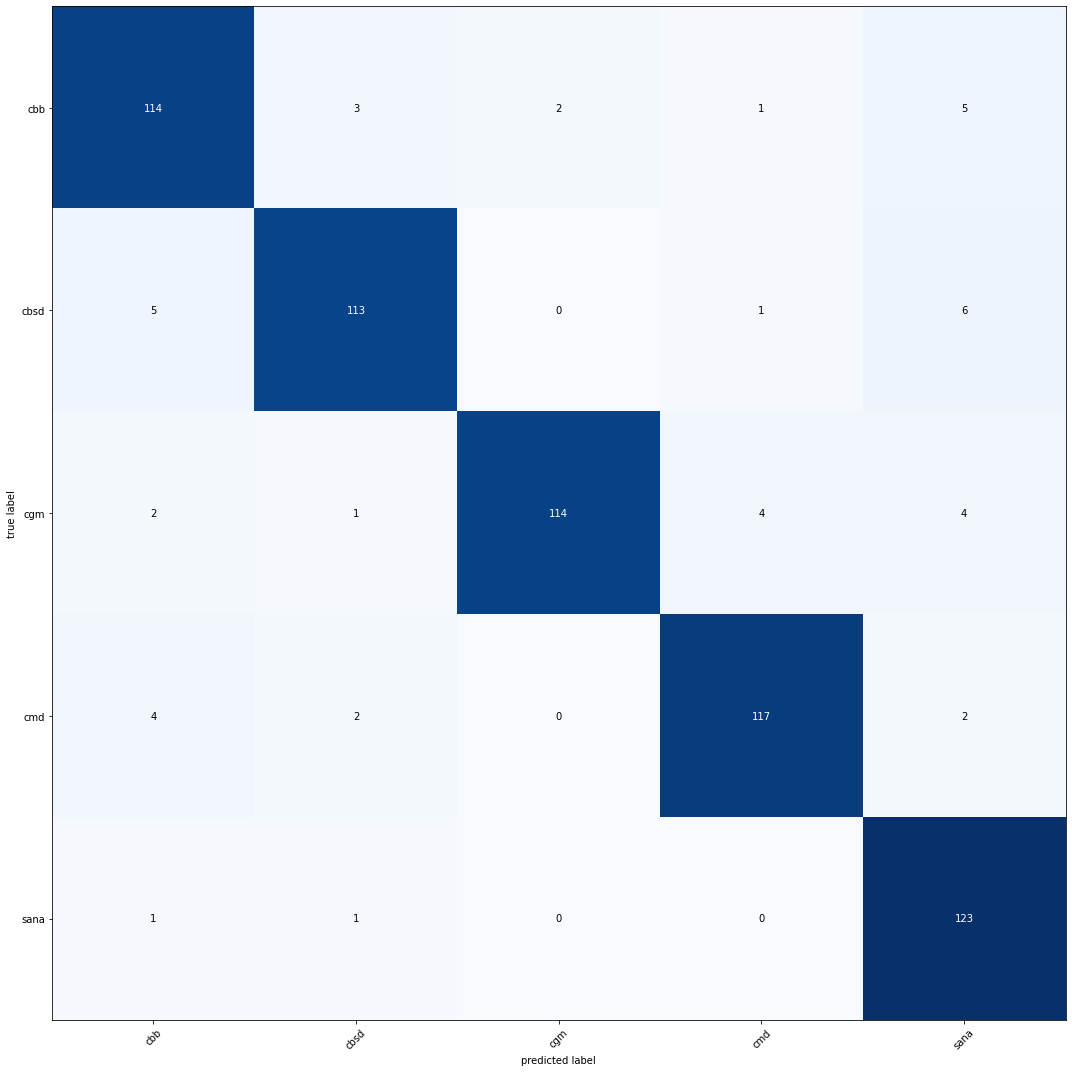

In [65]:
from sklearn.metrics import confusion_matrix, f1_score, roc_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn import metrics
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

names = ['cbb','cbsd','cgm','cmd','sana']

custom_Model= keras.models.load_model('Cassava_best_modelR2.h5')

predictions = custom_Model.predict_generator(generator=test_data_gen)

y_pred = np.argmax(predictions, axis=1)
y_real = test_data_gen.classes


matc=confusion_matrix(y_real, y_pred)

plot_confusion_matrix(conf_mat=matc, figsize=(15,15), class_names = names, show_normed=False)
plt.tight_layout()
print(metrics.classification_report(y_real,y_pred, digits = 4))